# Set Required Args to Activate Modules

In [1]:
import RES.RESources as RES

 └> Using CODERS API key: w0OksqQKMFMtKPbO


In [2]:
vis={}

In [3]:
# Iterate over provinces for both solar and wind resources
resource_types = ['wind','solar']  #
provinces=['BC']  #,'AB','SK','ON','NS','MB'
for province_code in provinces:
    for resource_type in resource_types:
        required_args = {
            "config_file_path": 'config/config_CAN.yaml',
            "region_short_code": province_code,
            "resource_type": resource_type
        }
        
        # Create an instance of Resources and execute the module
        RES_module = RES.RESources_builder(**required_args)
        # RES_module.build(select_top_sites=True,
        #                  use_pypsa_buses=False)
        

2025-06-29 06:55:58,824 - INFO - Directory 'data/downloaded_data/NREL/ATB/ATBe.parquet' found locally.


____________________________________________________________
     Initiating RESource Builder...
____________________________________________________________
 └> NREL_ATBProcessor initiated...
  └> Processing Annual Technology Baseline (ATB) data sourced from NREL...
  └> ATB cost datafile: ATBe.parquet loaded
  └> Extracting technology baseline costs...
  └─> Extracting Solar PV technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/solar'
  └─> Extracting Wind Turbine technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/wind'
  └─> Extracting BESS technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/bess'
 └> Snapshot for Resources: 2023-01-01 07:00:00 to 2024-01-01 06:00:00


2025-06-29 06:55:59,378 - INFO - Directory 'data/downloaded_data/NREL/ATB/ATBe.parquet' found locally.


____________________________________________________________
     Initiating RESource Builder...
____________________________________________________________
 └> NREL_ATBProcessor initiated...
  └> Processing Annual Technology Baseline (ATB) data sourced from NREL...
  └> ATB cost datafile: ATBe.parquet loaded
  └> Extracting technology baseline costs...
  └─> Extracting Solar PV technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/solar'
  └─> Extracting Wind Turbine technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/wind'
  └─> Extracting BESS technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/bess'
 └> Snapshot for Resources: 2023-01-01 07:00:00 to 2024-01-01 06:00:00


2025-06-29 06:55:59,858 - INFO - >> Loading GADM boundaries (Sub-provincial | level =2) for British Columbia  from local file data/processed_data/regions/gadm41_Canada_L2_BC.geojson.
2025-06-29 06:55:59,952 - INFO - Storing temporary files in /tmp/tmpy6_11e4n


 └> Preparing Grid Cells...

    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        


2025-06-29 06:56:00,458 - INFO - >> Loading GADM boundaries (Sub-provincial | level =2) for British Columbia  from local file data/processed_data/regions/gadm41_Canada_L2_BC.geojson.
2025-06-29 06:56:00,521 - INFO - Storing temporary files in /tmp/tmpnw3ssuqm
2025-06-29 06:56:00,524 - INFO - >> Loading GADM boundaries (Sub-provincial | level =2) for British Columbia  from local file data/processed_data/regions/gadm41_Canada_L2_BC.geojson.


>> Updated 'cells' saved to data/store/resources_BC.h5 with key 'cells'
>> Updated 'boundary' saved to data/store/resources_BC.h5 with key 'boundary'
  └> Grid Cells updated.
 └> Preparing Cells' capacity ...

    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        
  └> Loading global filters' rasters from GAEZ, trimmed to {self.region_name}
  └─> >> Raster file 'faocmb_2010.tif' found in local directory, skipping download.
  └─> >> Raster file 'slpmed05.tif' found in local directory, skipping download.
  └─> >> Raster file 'excl

2025-06-29 06:56:01,466 - INFO - >> Loading locally stored OSM data for 'aeroway' from data/downloaded_data/OSM/BC_aeroway.geojson


  └─> >> Raster plot saved at: vis/misc/exclusion_2017_raster_BC.png
  └─> All required rasters for GAEZ processed and plotted successfully.
  └> Loading Land_cover layers from data/downloaded_data/GAEZ/Rasters_in_use/LR/lco/BC_faocmb_2010.tif
  └> Loading Terrain_resources layers from data/downloaded_data/GAEZ/Rasters_in_use/LR/ter/BC_slpmed05.tif
  └> Loading Exclusion_areas layers from data/downloaded_data/GAEZ/Rasters_in_use/LR/excl/BC_exclusion_2017.tif
 └> Loading Canadian Protected and Conserved Areas Database (CPCAD) from locally stored datafile - {provincial_file_path}


2025-06-29 06:56:01,727 - INFO - Exclusion Container
 registered rasters: 3 
 registered geometry collections: 2
 CRS: 3347 - Resolution: 100


Land availability (grid cells) map saved at vis/misc/land_availability_ERA5grid_British Columbia.png
Land availability map (excluder resolution) saved at vis/misc/land_availability_excluderResolution_British Columbia.png


2025-06-29 06:56:46,515 - INFO - >> Saving to the local store (as HDF5 file)


>> Total ERA5 cells loaded : 2958 [each with .025 deg. (~30km) resolution ]
>> Updated 'cells' saved to data/store/resources_BC.h5 with key 'cells'
  └> Cells' capacity updated..


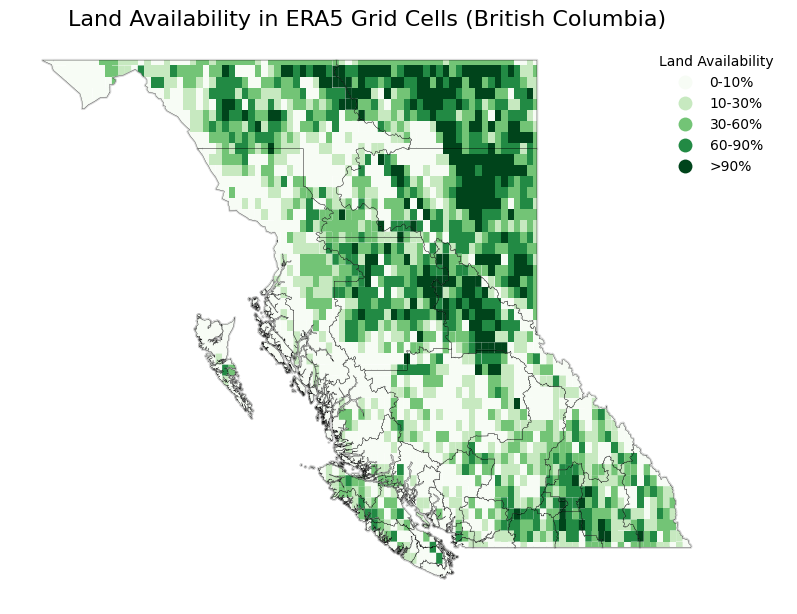

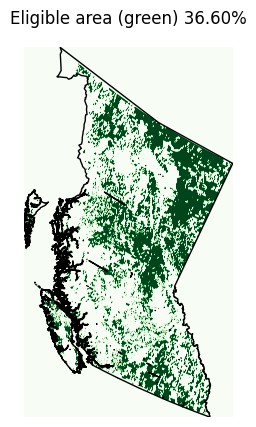

In [4]:
data1=RES_module.get_grid_cells()
data2=RES_module.get_cell_capacity()

In [12]:
data3=RES_module.extract_weather_data()

2025-06-29 06:58:35,584 - INFO - >> Loading GADM boundaries (Sub-provincial | level =2) for British Columbia  from local file data/processed_data/regions/gadm41_Canada_L2_BC.geojson.


2025-06-29 06:58:35,649 - INFO - Storing temporary files in /tmp/tmpqh9vbyli


 └> Extracting ERA5 weather data...

    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        


In [13]:
data4=RES_module.update_gwa_scaled_params() # testing, 2025 04 21

  └> GWA Cells not configured for solar.


In [14]:
data5=RES_module.get_CF_timeseries()

  └─> Preparing Timeseries for the Cells...


2025-06-29 06:58:35,730 - INFO - >> Loading ERA5 Cutout
2025-06-29 06:58:35,730 - INFO - >> Loading GADM boundaries (Sub-provincial | level =2) for British Columbia  from local file data/processed_data/regions/gadm41_Canada_L2_BC.geojson.


2025-06-29 06:58:35,797 - INFO - Storing temporary files in /tmp/tmpd_7wh2z1
2025-06-29 06:58:35,799 - INFO - >> 2948 Grid Cells from Store Cutout
2025-06-29 06:58:35,800 - INFO - Convert and aggregate 'pv'.



    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        


2025-06-29 06:59:34,701 - INFO - >> Calculating CF mean from the 8760 data points for each Cell ...
2025-06-29 06:59:34,732 - INFO - >> Total Grid Cells: 2948, >> Timeseries Generated for: 2948, >> Matched Sites: (8760, 2948)
2025-06-29 06:59:34,732 - INFO - >> Calculating 'solar_CF_mean' for 2948 Cells...


>> Updated 'cells' saved to data/store/resources_BC.h5 with key 'cells'
>> Updated 'timeseries/solar' saved to data/store/resources_BC.h5 with key 'timeseries/solar'


In [15]:
data6=RES_module.find_grid_nodes()

  └> Preparing grid nodes for the Cells...
  └─> Using Substations (sourced from CODERS) preferred nodes for resource connection.


2025-06-29 06:59:36,849 - INFO - >> Data pulled substations from [source checked: CODERS(https://sesit.dev/api/docs)]
2025-06-29 06:59:36,862 - INFO - substations data saved to:
 data/downloaded_data/CODERS/network/substations.pkl
2025-06-29 06:59:36,921 - INFO - >> Loading GADM boundaries (Sub-provincial | level =2) for British Columbia  from local file data/processed_data/regions/gadm41_Canada_L2_BC.geojson.
2025-06-29 06:59:36,987 - INFO - Storing temporary files in /tmp/tmpgj1c9qz0
2025-06-29 06:59:36,992 - INFO - > Calculating Nearest Grid Nodes for Grid Cells
2025-06-29 06:59:37,156 - INFO - ERA5 Cells Filtered based on Proximity to Tx Nodes 
Size: 1882




    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        
  └─> Searching for closest grid nodes for each cell...
  └─> Closest grid nodes and distance to them calculated and stored for each cell...
>> Updated 'cells' saved to data/store/resources_BC.h5 with key 'cells'
>> Updated 'substations' saved to data/store/resources_BC.h5 with key 'substations'


In [16]:
data7=RES_module.score_cells()

  └> Calculating score for cells...
>> Calculating Score for each Cell...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cells'


In [17]:
data8=RES_module.get_clusters()
data9=RES_module.get_cluster_timeseries()
data10=RES_module.units.create_units_dictionary()

 └> Preparing cluster of resources...
  └> Clustering requires scored cells. The default scoring method is set to 'lcoe'. Checking for 'lcoe' in datafields...
  └─> 'lcoe_solar' not found in available datafields...
  └> Calculating score for cells...
>> Calculating Score for each Cell...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cells'

=== Processing region: Stikine ===
Available columns in cells_scored: ['x_1', 'y_1', 'windspeed_gwa', 'CF_IEC2', 'CF_IEC3', 'x', 'y', 'potential_capacity_wind', 'capex_wind', 'fom_wind', 'vom_wind', 'grid_connection_cost_per_km_wind', 'tx_line_rebuild_cost_wind', 'Operational_life_wind', 'windspeed_ERA5', 'Country', 'Province', 'Region', 'geometry', 'wind_CF_mean', 'nearest_station', 'nearest_station_distance_km', 'lcoe_wind', 'potential_capacity_solar', 'capex_solar', 'fom_solar', 'vom_solar', 'grid_connection_cost_per_km_solar', 'tx_line_rebuild_cost_solar', 'Operational_life_solar', 'solar_CF_mean', 'lcoe_solar', 

2025-06-29 06:59:41,884 - INFO -  Creating cluster for Stikine 1/28
2025-06-29 06:59:41,900 - INFO -  Creating cluster for Kitimat-Stikine 2/28
2025-06-29 06:59:41,948 - INFO -  Creating cluster for Cariboo 3/28
2025-06-29 06:59:41,964 - INFO -  Creating cluster for Fraser-FortGeorge 4/28
2025-06-29 06:59:41,978 - INFO -  Creating cluster for Skeena-QueenCharlotte 5/28


Zone CentralOkanagan - Optimal k for LCOE_solar based clustering: 4

>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
Optimal-k based on 'LCOE' clustering calculated for 28 zones and saved to cell dataframe.

 └> Mapping the Optimal Number of Clusters for Each region ...
└>  Preparing Clusters...


2025-06-29 06:59:42,059 - INFO -  Creating cluster for PeaceRiver 6/28
2025-06-29 06:59:42,078 - INFO -  Creating cluster for MountWaddington 7/28
2025-06-29 06:59:42,130 - INFO -  Creating cluster for CentralCoast 8/28
2025-06-29 06:59:42,176 - INFO -  Creating cluster for PowellRiver 9/28
2025-06-29 06:59:42,191 - INFO -  Creating cluster for Bulkley-Nechako 10/28
2025-06-29 06:59:42,211 - INFO -  Creating cluster for Comox-Strathcona 11/28
2025-06-29 06:59:42,249 - INFO -  Creating cluster for NorthernRockies 12/28
2025-06-29 06:59:42,269 - INFO -  Creating cluster for Columbia-Shuswap 13/28
2025-06-29 06:59:42,288 - INFO -  Creating cluster for CowichanValley 14/28
2025-06-29 06:59:42,304 - INFO -  Creating cluster for Capital 15/28
2025-06-29 06:59:42,324 - INFO -  Creating cluster for Squamish-Lillooet 16/28
2025-06-29 06:59:42,341 - INFO -  Creating cluster for SunshineCoast 17/28
2025-06-29 06:59:42,360 - INFO -  Creating cluster for EastKootenay 18/28
2025-06-29 06:59:42,379 -

 └> Clusters Created and a list generated to map the Cells inside each Cluster...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'clusters/solar'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'dissolved_indices/solar'


2025-06-29 06:59:42,928 - INFO - >> Units information created and saved to 'data/units.csv'


 └>  Preparing representative profiles for 89 clusters
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'timeseries/clusters/solar'
>> Updated 'units' saved to data/store/resources_BC.h5 with key 'units'


Land availability (grid cells) map saved at vis/misc/land_availability_ERA5grid_British Columbia.png
Land availability map (excluder resolution) saved at vis/misc/land_availability_excluderResolution_British Columbia.png


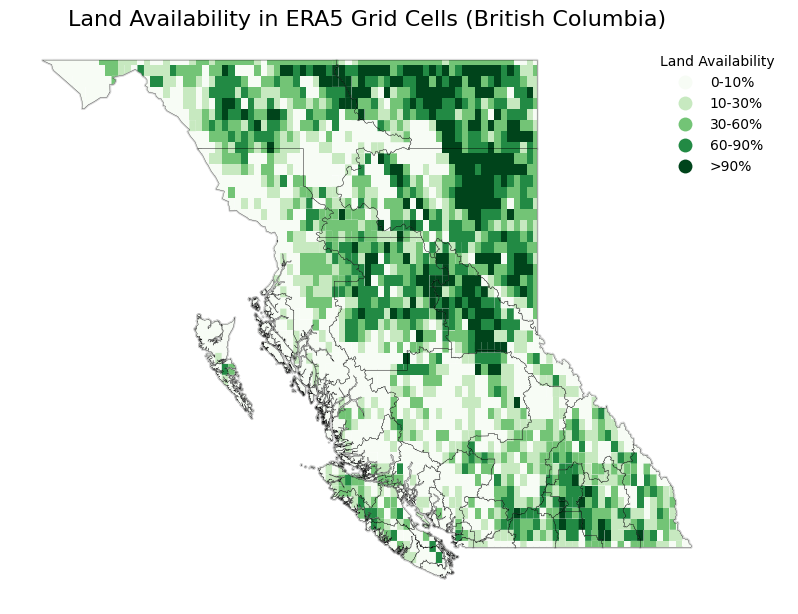

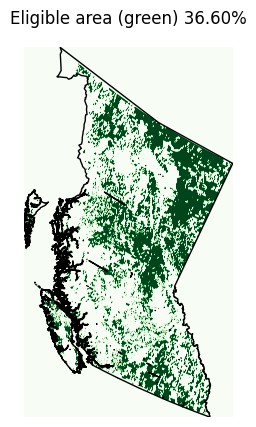

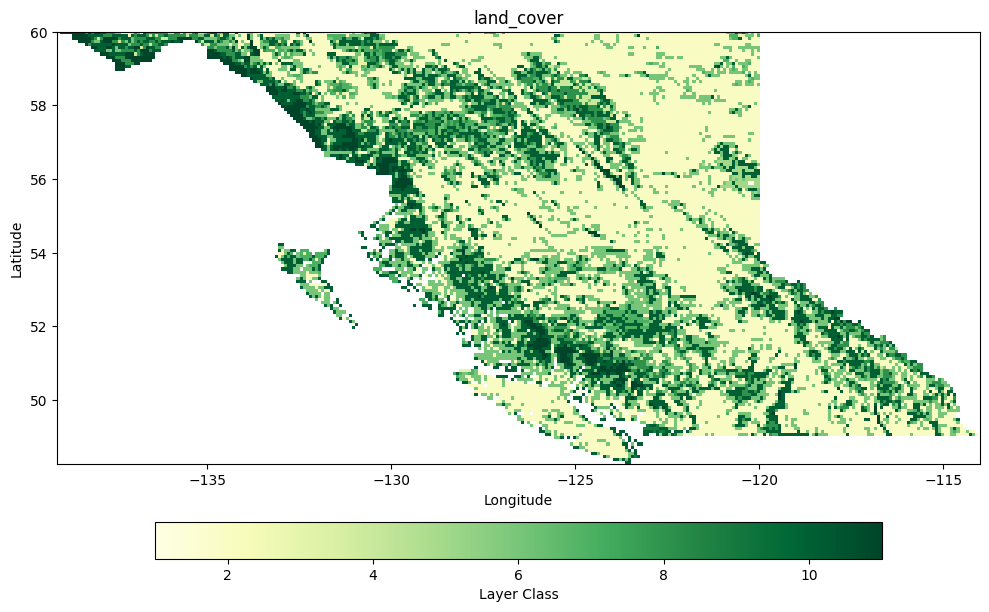

  └─> >> Raster plot saved at: vis/misc/faocmb_2010_raster_BC.png


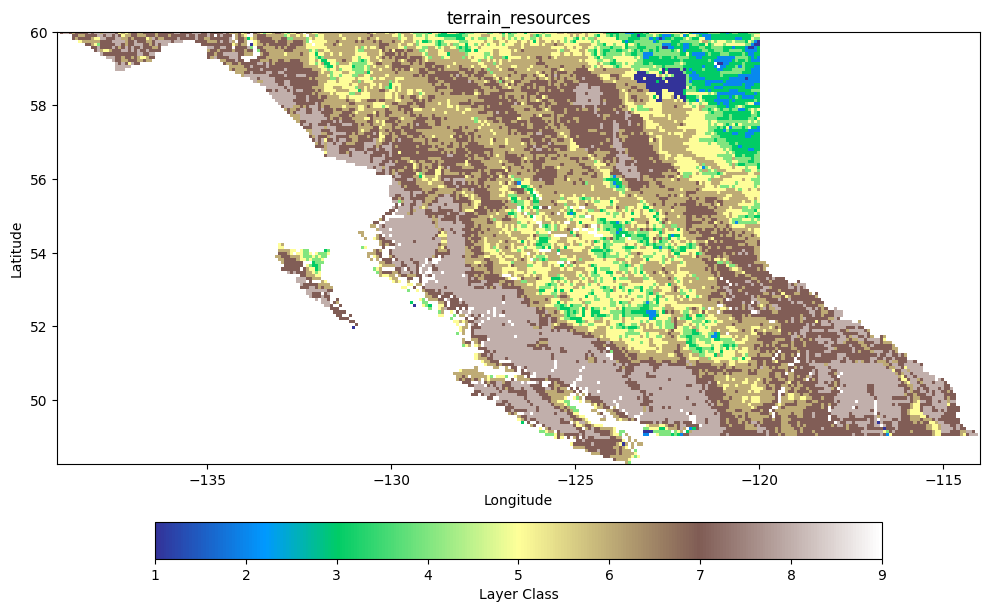

  └─> >> Raster plot saved at: vis/misc/slpmed05_raster_BC.png


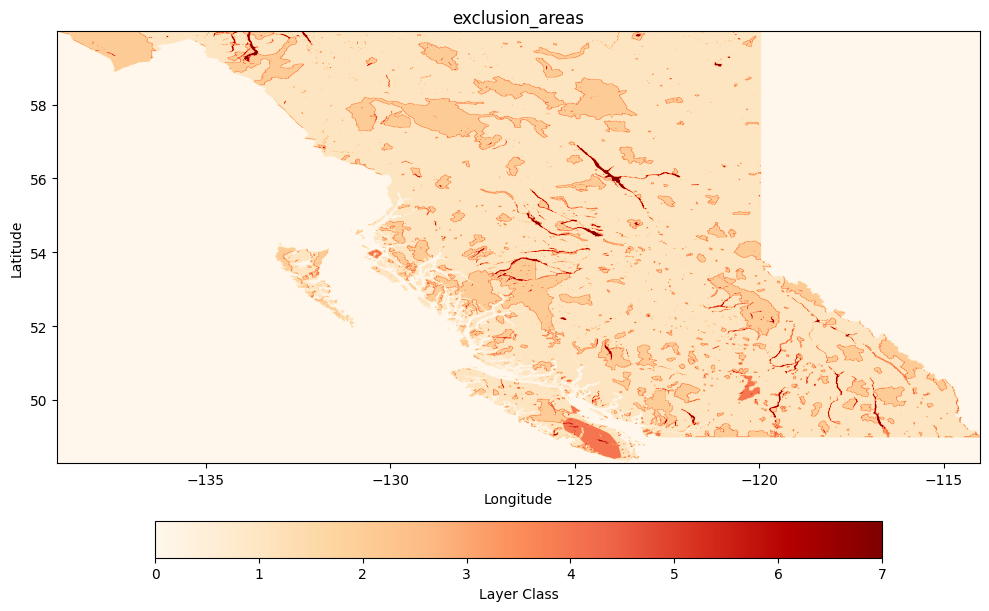

  └─> >> Raster plot saved at: vis/misc/exclusion_2017_raster_BC.png


In [26]:
vis['land_avail_1']=RES_module.cell_processor.plot_ERAF5_grid_land_availability()
vis['land_avail_2']=RES_module.cell_processor.plot_excluder_land_availability()
for raster_type in RES_module.cell_processor.raster_types:
            vis[f'land_vis_gaez_raster_{raster_type['name']}']=RES_module.cell_processor.__clip_to_boundary_n_plot__(raster_type, RES_module.cell_processor.region_boundary.geometry,True)

# Explore the outputs from Store

In [18]:
from RES.hdf5_handler import DataHandler
res_store=DataHandler(f'data/store/resources_{province_code}.h5')

In [19]:
cells=res_store.from_store('cells')
boundary=res_store.from_store('boundary')
solar_clusters=res_store.from_store('clusters/solar')
wind_clusters=res_store.from_store('clusters/wind')
solar_clusters_ts=res_store.from_store('timeseries/clusters/solar')
wind_clusters_ts=res_store.from_store('timeseries/clusters/wind')

In [20]:
# wind_clusters[wind_clusters['lcoe']<=100].explore('potential_capacity')

# Playground for Top Site Selection

In [21]:
resource_clusters_solar,cluster_timeseries_solar=RES_module.select_top_sites(solar_clusters,
                                                                solar_clusters_ts,
                                                                    resource_max_capacity=10)

resource_clusters_wind,cluster_timeseries_wind=RES_module.select_top_sites(wind_clusters,
                                                                wind_clusters_ts,
                                                                    resource_max_capacity=50)

>>> Selecting TOP Sites to for 10 GW Capacity Investment in BC...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 10 GW PV in BC
____________________________________________________________________________________________________

!! Note: The Last cluster (Okanagan-Similkameen_1) originally had 4.02 GW potential capacity.To fit the maximum capacity investment of 10 GW, it has been adjusted to 0.52 GW

>>> Selecting TOP Sites to for 50 GW Capacity Investment in BC...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 50 GW PV in BC
____________________________________________________________________________________________________

!! Note: The Last cluster (Thompson-Nicola_1) originally had 10.05 GW potential capacity.To fit the maximum capacity investment of 50 GW, it has been adjusted to 1.04 GW

In [22]:
RES_module.export_results('wind',
                    resource_clusters_wind,
                    cluster_timeseries_wind,)

wind clusters exported to :results


In [23]:
RES_module.export_results('solar',
                    resource_clusters_solar,
                    cluster_timeseries_solar,)

solar clusters exported to :results


In [24]:
# resource_clusters_solar.plot('potential_capacity',legend=True)
# resource_clusters_wind.plot('potential_capacity',legend=True)

# Visualize Results

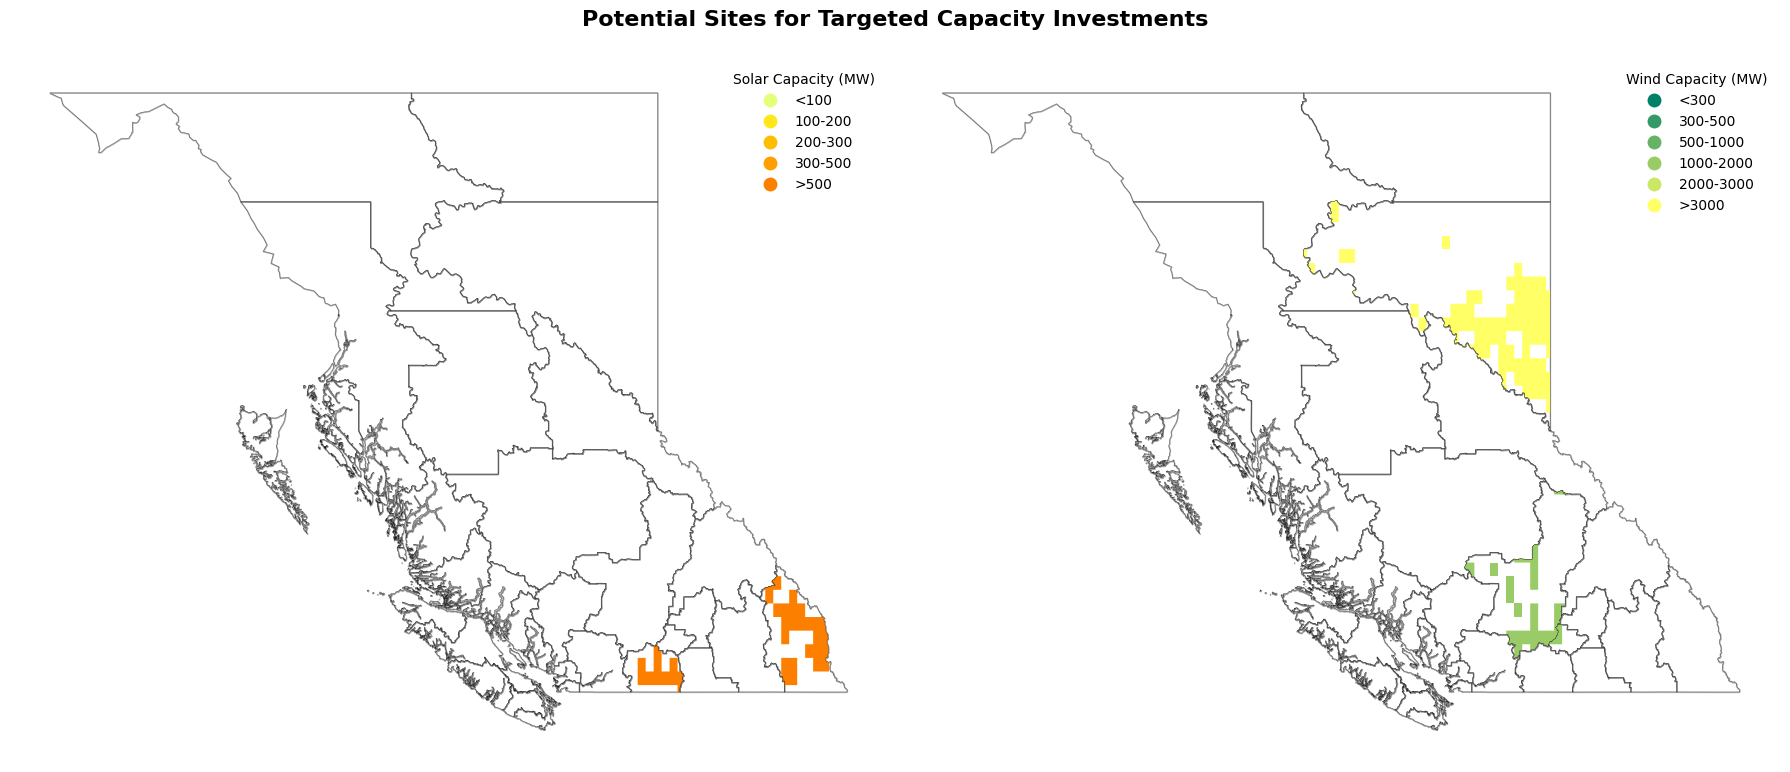

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

legend_x_ax_offset=1
# Ensure 'Region' is in the columns for both boundary and cells
if 'Region' not in boundary.columns:
    boundary = boundary.reset_index(inplace=True)

# Assign a number to each region
boundary['Region_Number'] = range(1, len(boundary) + 1)

# Define custom bins and labels for solar and wind capacity
solar_bins = [0, 100, 200, 300, 500, float('inf')]  # Custom ranges
solar_labels = ['<100','100-200', '200-300', '300-500','>500']  # Labels for legend

# Define custom bins and labels for solar and wind capacity
wind_bins = [0, 300, 500, 1000, 2000,3000, float('inf')]  # Custom ranges
wind_labels = ['<300','300-500', '500-1000', '1000-2000','2000-3000', '>3000']  # Labels for legend

# Categorize potential_capacity_solar and potential_capacity_wind into bins
resource_clusters_solar['solar_category'] = pd.cut(resource_clusters_solar['potential_capacity'], bins=solar_bins, labels=solar_labels, include_lowest=True)
resource_clusters_wind['wind_category'] = pd.cut(resource_clusters_wind['potential_capacity'], bins=wind_bins, labels=wind_labels, include_lowest=True)

# Create figure and axes for side-by-side plotting
fig, (ax1, ax2) = plt.subplots(figsize=(18, 8), ncols=2)
fig.suptitle("Potential Sites for Targeted Capacity Investments", fontsize=16,weight='bold')
# Set axis off for both subplots
ax1.set_axis_off()
ax2.set_axis_off()

# Shadow effect offset
shadow_offset = 0.01

# Plot solar map on ax1
# Add shadow effect for solar map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax1, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot solar cells
resource_clusters_solar.plot(column='solar_category', ax=ax1, cmap='Wistia', legend=True, 
           legend_kwds={'title': "Solar Capacity (MW)", 'loc': 'upper right','bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for solar map
boundary.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for solar map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax1.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=7, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Plot wind map on ax2
# Add shadow effect for wind map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax2, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot wind cells
resource_clusters_wind.plot(column='wind_category', ax=ax2, cmap='summer', legend=True, 
           legend_kwds={'title': "Wind Capacity (MW)", 'bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for wind map
boundary.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for wind map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax2.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=8, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Adjust layout for cleaner appearance
fig.patch.set_alpha(0)  # Make figure background transparent
plt.tight_layout()

# Show the side-by-side plot

# plt.savefig('solar_wind_capacity_map.png',dpi=300)
plt.show()